# 4 test cases – Density estimation

In [180]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(repr)

In [181]:
install.packages("cowplot")
library(cowplot)
install.packages("ggpubr")
library(ggpubr)
install.packages("mixtools")
library(mixtools)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [182]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [183]:
load(file = "data/flat_roofs.RData")

### Building 1 – b1128005c-00ba-11e6-b420-2bdcc4ab5d7f

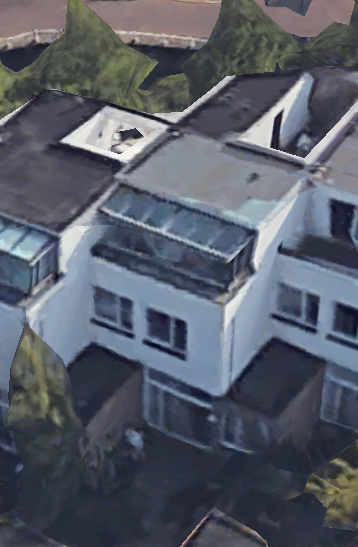

In [184]:
b1 <- allz_norm["b1128005c-00ba-11e6-b420-2bdcc4ab5d7f"]

### Building 2 – b112827a3-00ba-11e6-b420-2bdcc4ab5d7f

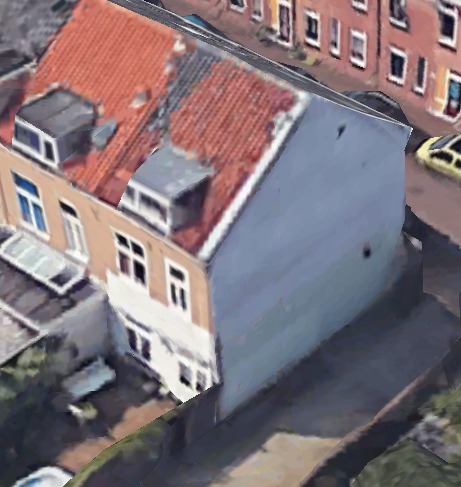

In [185]:
b2 <- allz_norm["b112827a3-00ba-11e6-b420-2bdcc4ab5d7f"]

### Building 3 – G0503.032e68f024c249cce0532ee22091b28c

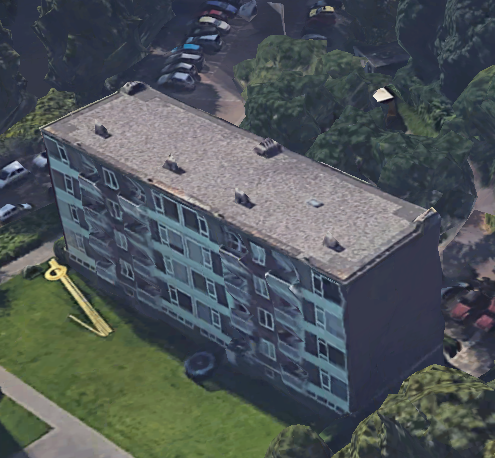

In [186]:
b3 <- allz_norm["G0503.032e68f024c249cce0532ee22091b28c"]

### Building 4 – b31bc9c46-00ba-11e6-b420-2bdcc4ab5d7f

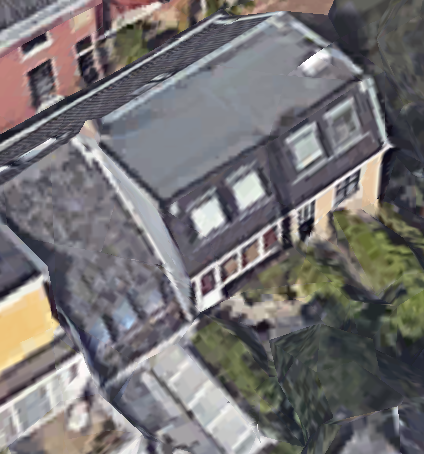

In [187]:
b4 <- allz_norm["b31bc9c46-00ba-11e6-b420-2bdcc4ab5d7f"]

In [188]:
allz_vert <- dplyr::bind_rows(data.frame(gml_id = rep(names(b1), length(b1[[1]])), z_norm = b1[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(b2), length(b2[[1]])), z_norm = b2[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(b3), length(b3[[1]])), z_norm = b3[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(b4), length(b4[[1]])), z_norm = b4[[1]], stringsAsFactors = FALSE))
head(allz_vert)
print(paste("sanity check passed: ", nrow(allz_vert) == sum(length(b1[[1]]), length(b2[[1]]), length(b3[[1]]), length(b4[[1]]))))

gml_id,z_norm
b1128005c-00ba-11e6-b420-2bdcc4ab5d7f,0.04
b1128005c-00ba-11e6-b420-2bdcc4ab5d7f,0.05
b1128005c-00ba-11e6-b420-2bdcc4ab5d7f,0.07
b1128005c-00ba-11e6-b420-2bdcc4ab5d7f,0.07
b1128005c-00ba-11e6-b420-2bdcc4ab5d7f,0.07
b1128005c-00ba-11e6-b420-2bdcc4ab5d7f,0.08


[1] "sanity check passed:  TRUE"


In [189]:
allz_vert <- dplyr::inner_join(allz_vert, roof_flat, by = "gml_id")
allz_vert$gml_id <- factor(allz_vert$gml_id, labels = c("b1", "b2", "b3", "b4"))
head(allz_vert)

gml_id,z_norm,roof_flat
b1,0.04,Flat
b1,0.05,Flat
b1,0.07,Flat
b1,0.07,Flat
b1,0.07,Flat
b1,0.08,Flat


## Gaussian kernel density estimate of the height values

In [190]:
theme_set(theme_cowplot(font_size=12)) # reduce default font size

If we assume that the underlying distribution is Gaussian, kernel density estimates can be used to identify modes in the data and split it accordingly. Ultimately the goal is to identify the cluster of height values in each building that correspond to the roof, whether it is single- or multi-level. Therefore we also need to assume that for each building, there is a large amount of points corresponding to the roof and significantly less points corresponding to the walls and ground. This assumption is based on the notion that the point cloud was collected by airborn laser scanning and it might not hold in different data sources.

In the density plots we can observe that the distribution of the height values is often multi-modal. Following my intution, I would expect uni-modal distribution in case of buildings with single level roofs (b2, b3, b4) and multi-modal distribution in case of a multi-level roof (b1). But *b3* exhibits a strong multi-modal distribution even though the building clearly has a single level roof.

Thus a simple and efficient method is to segment the height values at the locations where the density estimate reaches a minimum (**blue lines**). Then select the height values that are larger than the break point with the largest value (**red points**).

We need to set the smoothing bandwidth for the density estimation in order to get uniform results. $0.05$ standard deviation is an empirical value that I established after some experimentation. This value works the best for all the four cases.

In [191]:
bw = 0.5

### Building 1

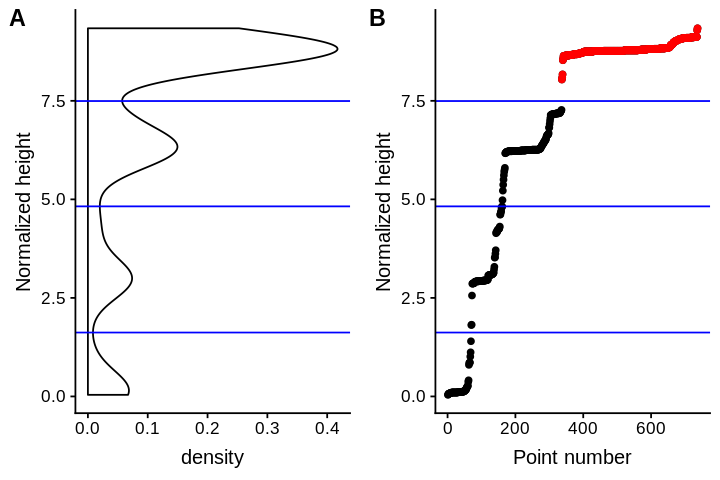

In [192]:
dens <- density(b1[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "b1"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(b1[[1]])), z_norm = b1[[1]])
b1.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = b1.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

### Building 2

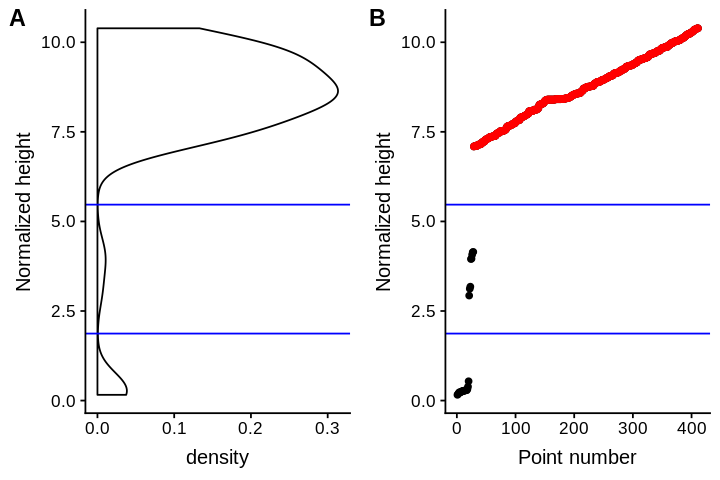

In [193]:
dens <- density(b2[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "b2"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(b2[[1]])), z_norm = b2[[1]])
b2.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = b2.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

### Building 3

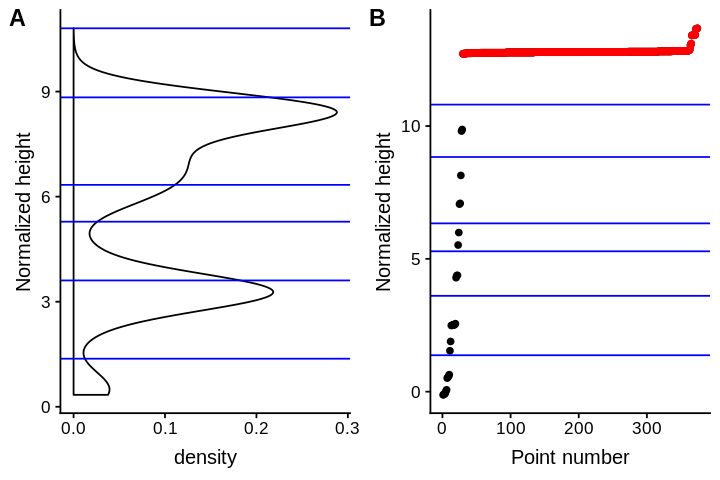

In [194]:
dens <- density(b3[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "b3"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(b3[[1]])), z_norm = b3[[1]])
b3.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = b3.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

### Building 4

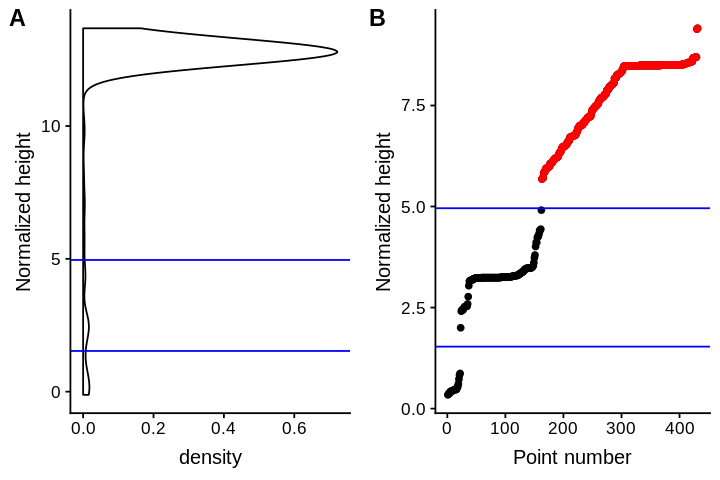

In [195]:
dens <- density(b4[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "b4"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(b4[[1]])), z_norm = b4[[1]])
b4.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = b4.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

## The subsampled height values

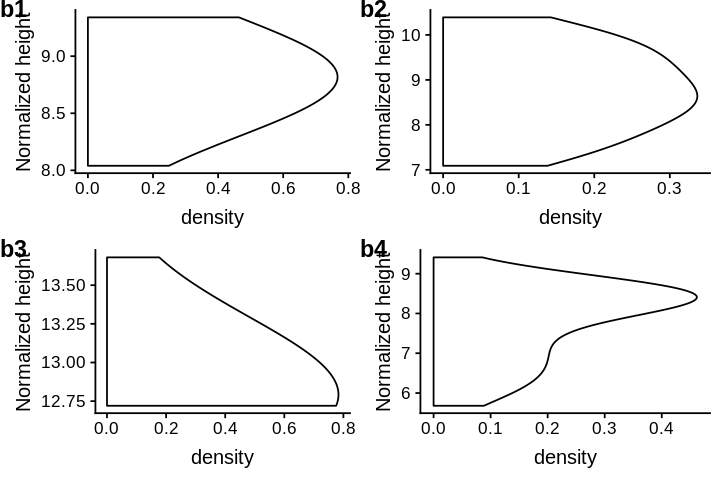

In [196]:
plot.b1 <- ggplot(b1.roof, aes(z_norm)) + 
    geom_density(bw = bw) + 
    coord_flip() + labs(x = "Normalized height")
plot.b2 <- ggplot(b2.roof, aes(z_norm)) + 
    geom_density(bw = bw) + 
    coord_flip() + labs(x = "Normalized height")
plot.b3 <- ggplot(b3.roof, aes(z_norm)) + 
    geom_density(bw = bw) + 
    coord_flip() + labs(x = "Normalized height")
plot.b4 <- ggplot(b4.roof, aes(z_norm)) + 
    geom_density(bw = bw) + 
    coord_flip() + labs(x = "Normalized height")
plot_grid(plot.b1, plot.b2, plot.b3, plot.b4, labels = c("b1", "b2", "b3", "b4"), hjust = 0, vjust = 1)

### Compare variances

In [197]:
print(paste("Variance b1:", round(var(b1.roof$z_norm), 5)))
print(paste("Variance b2:", round(var(b2.roof$z_norm), 5)))
print(paste("Variance b3:", round(var(b3.roof$z_norm), 5)))
print(paste("Variance b4:", round(var(b4.roof$z_norm), 5)))

[1] "Variance b1: 0.02215"
[1] "Variance b2: 0.8473"
[1] "Variance b3: 0.01446"
[1] "Variance b4: 0.84962"


The two flat roofs should have similar variances, but the F-test indicates that the variances are significantly different. Maybe its better if I don't normalize the data.

In [198]:
var.test(b1.roof$z_norm, b3.roof$z_norm)


	F test to compare two variances

data:  b1.roof$z_norm and b3.roof$z_norm
F = 1.5312, num df = 400, denom df = 344, p-value = 5.008e-05
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.247513 1.876517
sample estimates:
ratio of variances 
          1.531242 


In [199]:
t.test(b1.roof$z_norm, b3.roof$z_norm)


	Welch Two Sample t-test

data:  b1.roof$z_norm and b3.roof$z_norm
t = -404.19, df = 741.16, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.003088 -3.964389
sample estimates:
mean of x mean of y 
 8.820175 12.803913 


The two not-flat roofs should also have similar variances

In [200]:
var.test(b2.roof$z_norm, b4.roof$z_norm)


	F test to compare two variances

data:  b2.roof$z_norm and b4.roof$z_norm
F = 0.99726, num df = 382, denom df = 268, p-value = 0.9753
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7975673 1.2415405
sample estimates:
ratio of variances 
         0.9972607 


Then comparing flat to not-flat should be divided.

In [201]:
var.test(b1.roof$z_norm, b2.roof$z_norm)


	F test to compare two variances

data:  b1.roof$z_norm and b2.roof$z_norm
F = 0.026136, num df = 400, denom df = 382, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.02142409 0.03187045
sample estimates:
ratio of variances 
        0.02613636 


In [202]:
var.test(b1.roof$z_norm, b4.roof$z_norm)


	F test to compare two variances

data:  b1.roof$z_norm and b4.roof$z_norm
F = 0.026065, num df = 400, denom df = 268, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.02088385 0.03237489
sample estimates:
ratio of variances 
        0.02606477 


In [203]:
var.test(b3.roof$z_norm, b2.roof$z_norm)


	F test to compare two variances

data:  b3.roof$z_norm and b2.roof$z_norm
F = 0.017069, num df = 344, denom df = 382, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.01389407 0.02099247
sample estimates:
ratio of variances 
        0.01706874 


In [204]:
var.test(b3.roof$z_norm, b4.roof$z_norm)


	F test to compare two variances

data:  b3.roof$z_norm and b4.roof$z_norm
F = 0.017022, num df = 344, denom df = 268, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.01355326 0.02130972
sample estimates:
ratio of variances 
        0.01702198 


### Variance testing doesn't work, so try other

In [205]:
roof_var <- roof_flat
for (n in names(allz_norm)) {
    dat <- allz_norm[[n]]
    dens <- density(dat, bw = bw)
    minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
    roof_points <- dat[dat > max(minima)]
    roof_var[roof_var$gml_id == n, "roof_var"] <- var(roof_points)
}

Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”Warning message in max(minim

Number of buildings where it was impossible to compute minima:

In [206]:
sum(is.na(roof_var$roof_var))
roof_var <- na.omit(roof_var)

[1] 5

Okay, this could be something if we use a Gaussian Mixture model for clustering.

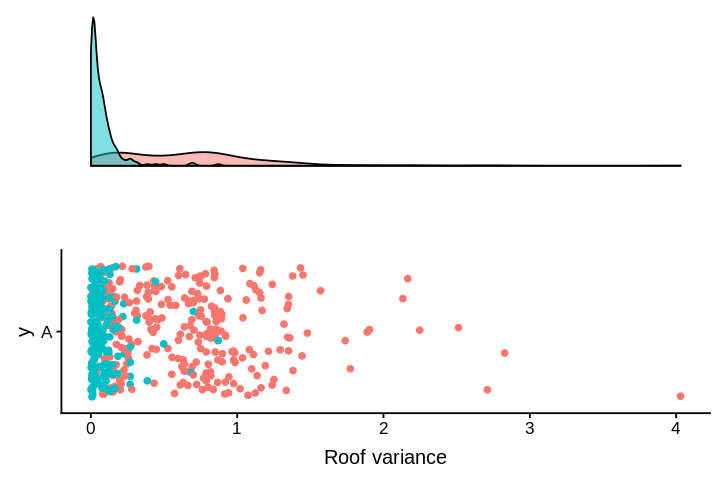

In [207]:
sp <- ggplot(roof_var, aes(roof_var, "A", color = roof_flat)) + geom_jitter() + labs(x = "Roof variance")          
# Marginal density plot of x (top panel) and y (right panel)
xplot <- ggdensity(roof_var, "roof_var", fill = "roof_flat")
# Cleaning the plots
sp <- sp + rremove("legend")
xplot <- xplot + clean_theme() + rremove("legend")
# Arranging the plot using cowplot
plot_grid(xplot, sp, ncol = 1, align = "hv")

[Reference](https://tinyheero.github.io/2015/10/13/mixture-model.html) for Gaussian mixture modelling

In [208]:
roof = roof_var$roof_var
mixmdl = normalmixEM(roof, k = 2)

number of iterations= 26 


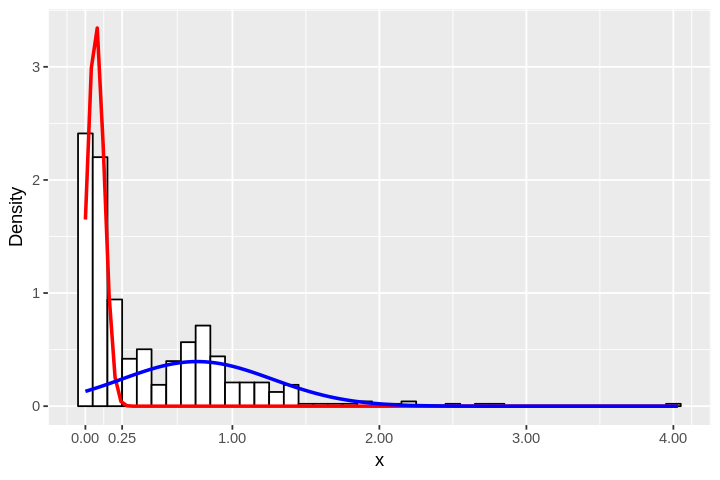

In [209]:
plot_mix_comps <- function(x, mu, sigma, lam) {
  lam * dnorm(x, mu, sigma)
}
ggplot2::theme_set(theme_gray())
data.frame(x = mixmdl$x) %>%
  ggplot() +
  geom_histogram(aes(x, ..density..), binwidth = 0.1, colour = "black", 
                 fill = "white") +
  stat_function(geom = "line", fun = plot_mix_comps,
                args = list(mixmdl$mu[1], mixmdl$sigma[1], lam = mixmdl$lambda[1]),
                colour = "red", lwd = 1.0) +
  stat_function(geom = "line", fun = plot_mix_comps,
                args = list(mixmdl$mu[2], mixmdl$sigma[2], lam = mixmdl$lambda[2]),
                colour = "blue", lwd = 1.0) +
  labs(y = "Density") +
scale_x_continuous(breaks = c(0,0.25,1,2,3,4))

In [210]:
post.df <- as.data.frame(cbind(roof_var = mixmdl$x, mixmdl$posterior))
filter(post.df, roof_var <= 0.25 & roof_var > 0.2) %>% 
arrange(comp.1, roof_var)

roof_var,comp.1,comp.2
0.2451902,0.1276147,0.8723853
0.2352378,0.1982515,0.8017485
0.2312861,0.2320279,0.7679721
0.2299406,0.2442123,0.7557877
0.2273171,0.2688872,0.7311128
0.2263288,0.2784751,0.7215249
0.2247536,0.2940597,0.7059403
0.2183496,0.3605215,0.6394785
0.2153801,0.3924893,0.6075107
0.2110320,0.4397830,0.5602170


Because the variance of 0.25 seems like a good place to cut and it also logically makes sense (variation of 25cm in height in flat roof), we set the threshold for the posterior probability for flat roof (comp.1) at 0.3.

In [212]:
flat_threshold = 0.6

In [213]:
roof_var_labs <- roof_var %>%
inner_join(post.df, by = "roof_var") %>% 
mutate(label = ifelse(comp.1 > flat_threshold, "Flat", "Not flat")) %>%
rename(prob_flat = comp.1, prob_not_flat = comp.2)
print(paste("Accuracy:", round(sum(roof_var_labs$roof_flat == roof_var_labs$label) / nrow(roof_var_labs) , 2)*100, "%"))
head(roof_var_labs, 6)

[1] "Accuracy: 84 %"


gml_id,roof_flat,roof_var,prob_flat,prob_not_flat,label
b31e1feb1-00ba-11e6-b420-2bdcc4ab5d7f,Flat,0.01002564,9.367265e-01,0.06327345,Flat
b31bc26a8-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,1.31978825,1.343580e-100,1.00000000,Not flat
b31bdfb7f-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0.86784342,5.616576e-41,1.00000000,Not flat
b31be49eb-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0.52719564,2.803221e-13,1.00000000,Not flat
b31bbd90d-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,2.13248482,1.940049e-273,1.00000000,Not flat
b112715ef-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0.81880975,4.461430e-36,1.00000000,Not flat


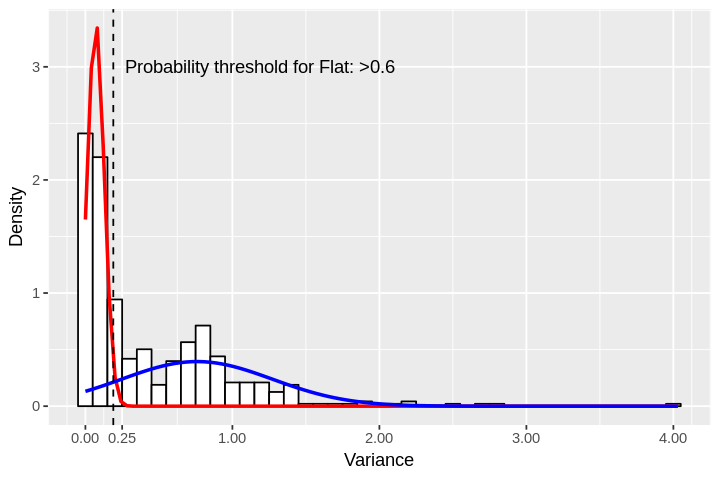

In [214]:
vint = filter(post.df, comp.1 > flat_threshold) %>% arrange(desc(roof_var)) %>% select(roof_var) %>% slice(1)
data.frame(x = mixmdl$x) %>%
  ggplot() +
  geom_histogram(aes(x, ..density..), binwidth = 0.1, colour = "black", 
                 fill = "white") +
  stat_function(geom = "line", fun = plot_mix_comps,
                args = list(mixmdl$mu[1], mixmdl$sigma[1], lam = mixmdl$lambda[1]),
                colour = "red", lwd = 1.0) +
  stat_function(geom = "line", fun = plot_mix_comps,
                args = list(mixmdl$mu[2], mixmdl$sigma[2], lam = mixmdl$lambda[2]),
                colour = "blue", lwd = 1.0) +
  labs(y = "Density", x = "Variance") +
  geom_vline(xintercept = vint[1,], linetype = "dashed") +
  annotate("text", x = vint[1,] + 1, y = 3, label = paste0("Probability threshold for Flat: >", flat_threshold)) +
  scale_x_continuous(breaks = c(0,0.25,1,2,3,4))

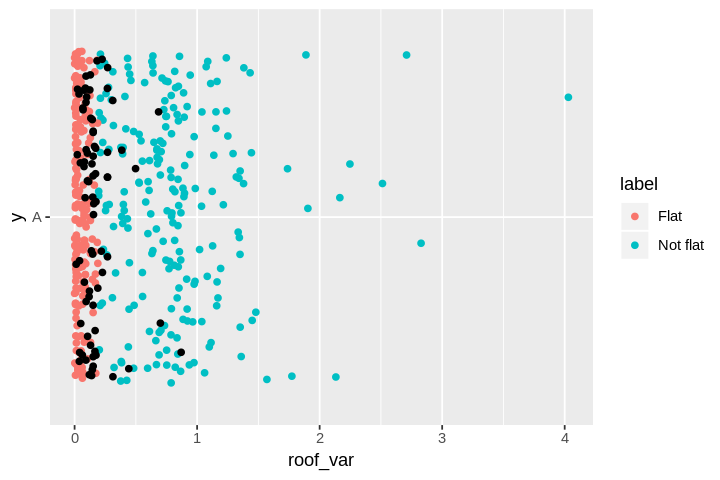

In [215]:
correct <- filter(roof_var_labs, roof_flat == label)
incorrect <- filter(roof_var_labs, roof_flat != label)
ggplot(correct, aes(roof_var, "A", color = label)) + 
geom_jitter() +
geom_jitter(data = incorrect, color = "black")

In [216]:
write.csv(roof_var_labs, "data/delft_mixm_res.csv", row.names = FALSE)

### Evaluation of incorrect labels

There seem to be two main issues:

1. The method for finding the subset/distribution of the points in the roof occaisonally fails

2. When no minimum is found on the density curve, it returns inf so these cases will be invalid

In [240]:
e1 <- allz_norm["G0503.032e68f02a2349cce0532ee22091b28c"]
e2 <- allz_norm["G0503.032e68f0012149cce0532ee22091b28c"]
e3 <- allz_norm["G0503.032e68efffd249cce0532ee22091b28c"]
e4 <- allz_norm["G0503.032e68f0276b49cce0532ee22091b28c"]
e5 <- allz_norm["G0503.032e68f02a2449cce0532ee22091b28c"]
e6 <- allz_norm["G0503.032e68f0550a49cce0532ee22091b28c"]

allz_vert <- dplyr::bind_rows(data.frame(gml_id = rep(names(e1), length(e1[[1]])), z_norm = e1[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(e2), length(e2[[1]])), z_norm = e2[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(e3), length(e3[[1]])), z_norm = e3[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(e4), length(e4[[1]])), z_norm = e4[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(e5), length(e5[[1]])), z_norm = e5[[1]], stringsAsFactors = FALSE),
                              data.frame(gml_id = rep(names(e6), length(e6[[1]])), z_norm = e6[[1]], stringsAsFactors = FALSE),)

print(paste("sanity check passed: ", nrow(allz_vert) == sum(length(e1[[1]]), length(e2[[1]]), length(e3[[1]]), 
                                                            length(e4[[1]]), length(e5[[1]]), length(e6[[1]])
                                                           )))

allz_vert <- dplyr::inner_join(allz_vert, roof_flat, by = "gml_id")
allz_vert$gml_id <- factor(allz_vert$gml_id, labels = c("e1", "e2", "e3", "e4", "e5", "e6"))

[1] "sanity check passed:  TRUE"


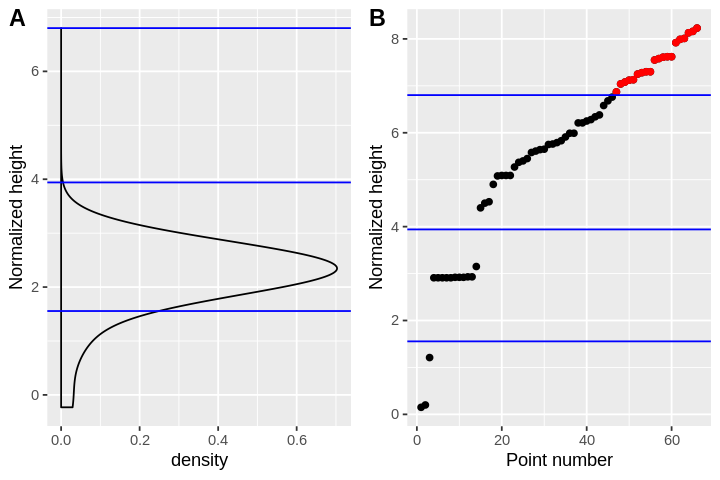

In [236]:
dens <- density(e1[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "e1"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(e1[[1]])), z_norm = e1[[1]])
e1.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = e1.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

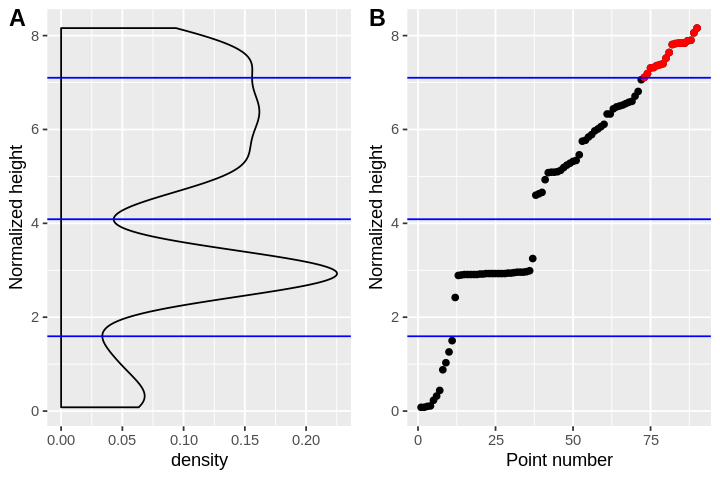

In [237]:
dens <- density(e2[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "e2"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(e2[[1]])), z_norm = e2[[1]])
e2.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = e2.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”

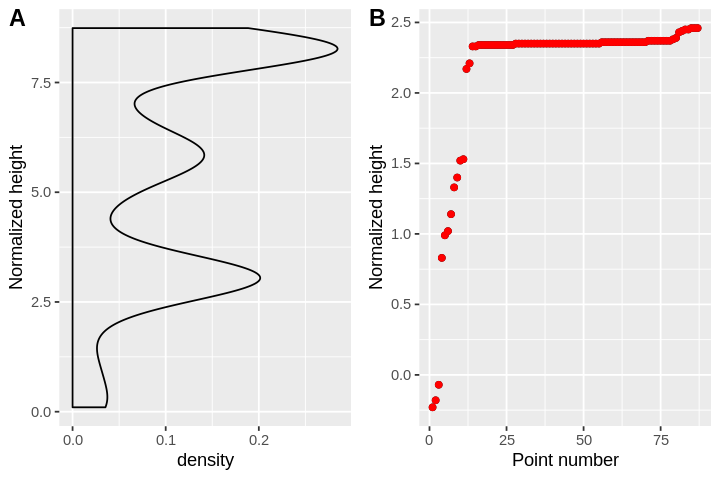

In [238]:
dens <- density(e3[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "e3"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(e3[[1]])), z_norm = e3[[1]])
e3.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = e3.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

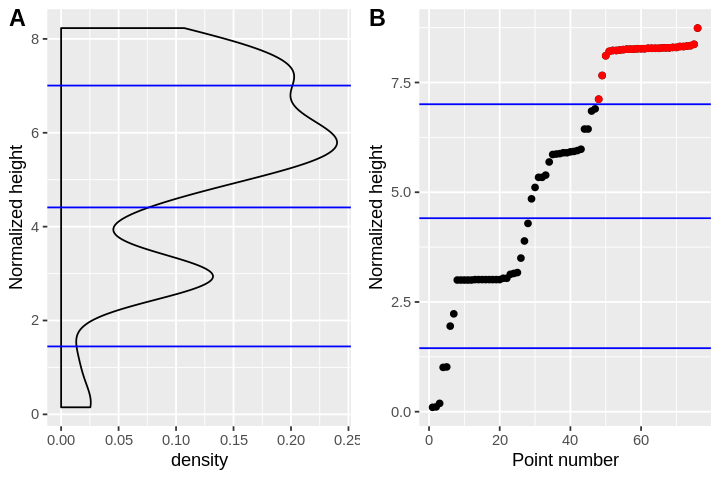

In [239]:
dens <- density(e4[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "e4"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(e4[[1]])), z_norm = e4[[1]])
e4.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = e4.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

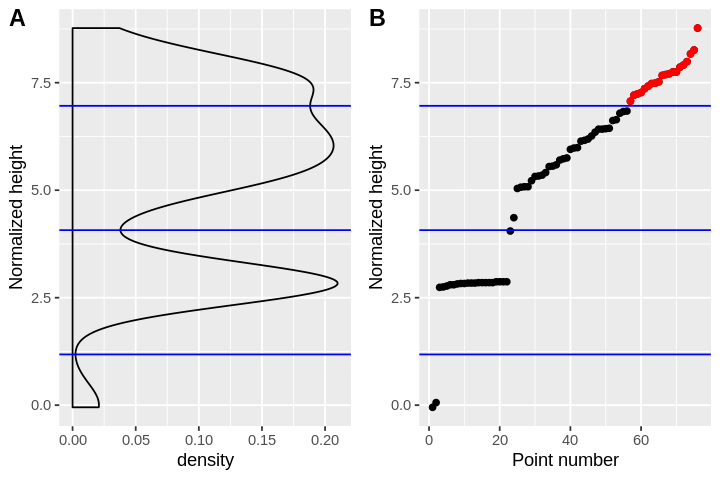

In [241]:
dens <- density(e5[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "e5"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(e5[[1]])), z_norm = e5[[1]])
e5.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = e5.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

Warning message in max(minima):
“no non-missing arguments to max; returning -Inf”

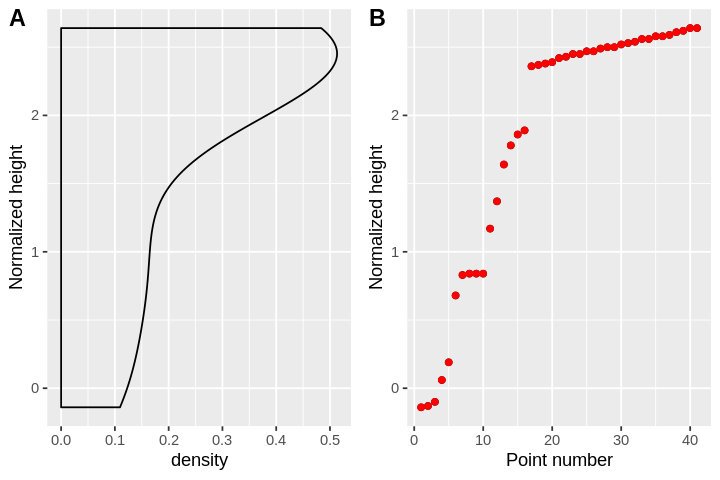

In [242]:
dens <- density(e6[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]
plot.dens <- ggplot(dplyr::filter(allz_vert, gml_id == "e6"), aes(z_norm)) + 
    geom_density(bw = bw) + 
    geom_vline(xintercept = minima,
              color = "blue") +
    coord_flip() + labs(x = "Normalized height")
x <- data.frame(rn = seq(1, length(e6[[1]])), z_norm = e6[[1]])
e6.roof <- x[x$z_norm > max(minima), ]
plot.scatter <- ggplot(x, aes(rn, z_norm)) + 
    geom_point() + 
    geom_point(data = e6.roof, color = "red") +
    geom_hline(yintercept = minima,
              color = "blue") +
    labs(y="Normalized height", x = "Point number")
plot_grid(plot.dens, plot.scatter, labels = c('A', 'B'))

In [256]:
typeof(dens$x[which(diff(sign(diff(dens$y)))==2)+1])

[1] "double"

In [266]:
length(0.1)

[1] 1

In [267]:
dens <- density(e3[[1]], bw = bw)
minima <- dens$x[which(diff(sign(diff(dens$y)))==2)+1]

In [269]:
minima

numeric(0)